In [1]:
import numpy as np
import pandas as pd
import ta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf

C:\Users\juini\anaconda3\envs\py38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Users\juini\anaconda3\envs\py38\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [10]:
symbols = ['EURUSDmicro','GBPUSDmicro','USDCHFmicro','USDJPYmicro','USDCADmicro']

timeframe = 'D1'

df = pd.read_csv("data/"+ symbols[1]+ timeframe+ ".csv")
df = df[['Date','Open','High','Low','Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Return'] =   df['Close'].pct_change() # Retorno percentual
df['Returnshift'] = df['Return'].shift(-1)
df['Alta/Baixa'] = [1 if x >= 0 else 0 for x in df['Return']] # dia de alta ou de baixa

df['A'] = df['High'] / df['Low']   # Razão entre a máxima e mínima do candle

df['B'] = (abs(df['Close'] - df['Open'])) / (df['High'] - df['Low'])  # Razão entre o corpo e a amplitude do candle

sombra1 = (df['High'] - df['Close']) / (df['Open'] - df['Low'])
sombra2 = (df['High'] - df['Open']) / (df['Close'] - df['Low'])

df['C'] = [sombra1.loc[x] if df.loc[x, 'Alta/Baixa'] == 1 else sombra2.loc[x] for x in df.index] # Razão entre a sombra superior e inferior

df['D'] = df['Close'] / df['Close'].shift(1) # Razão entre o fechamento de Hoje e o de x dias anteriores

df['E'] = df['Close'] - df['Close'].rolling(8).mean() # Distância entre o preço de hoje e a média curta

df['F'] = df['Close'] - df['Close'].rolling(80).mean() # Distância entre o preço de hoje e a média Longa

df['G'] = df['Close'].rolling(8).mean() - df['Close'].rolling(80).mean() # Distância entre o preço das duas médias

df['H'] = df['Return'].rolling(5).std() # Volatildiade dos últimos x dias

df['I'] = df['H'].rolling(5).sum() # Volatildiade acumulada dos últimos x dias

df['A2'] = df['A'].shift(1)
df['B2'] = df['B'].shift(1)
df['C2'] = df['C'].shift(1)
df.C.replace([np.inf, -np.inf], 0, inplace=True)
df.C2.replace([np.inf, -np.inf], 0, inplace=True)
df['D2'] = df['D'].shift(1)
df['E2'] = df['E'].shift(1)
df['F2'] = df['F'].shift(1)
df['G2'] = df['G'].shift(1)
df['H2'] = df['H'].shift(1)
df['I2'] = df['I'].shift(1)

df['Amplitude'] = df['Close'].shift(-1) - df['Close']
df['Amplitude2'] = df['Close'].shift(-2) - df['Close']
df['Amplitude3'] = df['Close'].shift(-3) - df['Close']

df['alvo'] = [1 if x >= 0 else 0 for x in df['Amplitude']]
df['alvo2'] = [1 if x >= 0 else 0 for x in df['Amplitude2']]
df['alvo3'] = [1 if x >= 0 else 0 for x in df['Amplitude3']]

df.dropna(inplace=True)

df.set_index ('Date', inplace = True)

df.tail()

,Open,High,Low,Close,Return,Returnshift,Alta/Baixa,A,B,C,...,F2,G2,H2,I2,Amplitude,Amplitude2,Amplitude3,alvo,alvo2,alvo3
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-18 08:00:00,1.29583,1.29765,1.29515,1.29684,0.000779,0.001303,1,1.001930,0.404000,1.191176,...,0.006000,0.006039,0.001598,0.010682,0.00169,0.00130,-0.00013,1,1,0
2020-09-18 10:00:00,1.29693,1.29933,1.29647,1.29853,0.001303,-0.000300,1,1.002206,0.559441,1.739130,...,0.007041,0.006341,0.001587,0.008112,-0.00039,-0.00182,-0.00249,0,0,0
2020-09-18 12:00:00,1.29849,1.29989,1.29695,1.29814,-0.000300,-0.001102,0,1.002267,0.119048,1.176471,...,0.008764,0.006975,0.001696,0.007493,-0.00143,-0.00210,-0.00311,0,0,0
2020-09-18 14:00:00,1.29819,1.29899,1.29546,1.29671,-0.001102,-0.000517,0,1.002725,0.419263,0.640000,...,0.008384,0.007257,0.001707,0.008294,-0.00067,-0.00168,-0.00419,0,0,0
2020-09-18 16:00:00,1.29670,1.29728,1.29316,1.29604,-0.000517,-0.000779,0,1.003186,0.160194,0.201389,...,0.006993,0.007251,0.001049,0.007636,-0.00101,-0.00352,-0.00451,0,0,0


In [11]:
indicador_bb = ta.volatility.BollingerBands(close = df['Close'], n = 20, ndev = 2, fillna = False)
indicador_rsi = ta.momentum.RSIIndicator(close = df['Close'], n = 14, fillna = False)
indicador_macd = ta.trend.MACD(close = df['Close'], n_slow = 26, n_fast = 12, n_sign = 9, fillna = False)

df['bb'] = indicador_bb.bollinger_pband()
df['bbH'] = indicador_bb.bollinger_hband_indicator() 
df['bbL'] = indicador_bb.bollinger_lband_indicator() 


df['rsi'] = indicador_rsi.rsi()
df['rsiH'] = [1 if x > 70  else 0 for x in indicador_rsi.rsi()]
df['rsiL'] = [1 if x < 30  else 0 for x in indicador_rsi.rsi()]

df['macd'] =  indicador_macd.macd_diff()
df['macdH'] =  [1 if x > 0 else 0 for x in indicador_macd.macd_diff()]
df['macdL'] =  [1 if x < 0 else 0 for x in indicador_macd.macd_diff()]

df.dropna(inplace=True)
#df

In [28]:
variaveis = [ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2',
             'H2', 'I2']
X = df[variaveis]
y = df['alvo2']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = X[0:1200], X[1200:], y[0:1200], y[1200:]

In [29]:
random = RandomForestClassifier()

In [30]:
random = random.fit(X_train,y_train)

In [31]:
resultadoRandom = random.predict(X_test)

In [32]:
from sklearn import metrics
print(metrics.classification_report(resultadoRandom,y_test))

              precision    recall  f1-score   support

           0       0.47      0.50      0.49     10098
           1       0.54      0.51      0.52     11463

    accuracy                           0.51     21561
   macro avg       0.51      0.51      0.51     21561
weighted avg       0.51      0.51      0.51     21561



In [84]:
result = np.append( random.predict(X_train), random.predict(X_test), 0)
df['Predict'] = result

In [85]:
df['Bull'] = [df.loc[x, 'Amplitude'] if df.loc[x, 'Predict'] == 1 else 0 for x in df.index]

df['Bear'] = [ - df.loc[x, 'Amplitude'] if df.loc[x, 'Predict'] == 0 else 0 for x in df.index]

df['ResultCum'] = np.cumsum(df['Bull'] + df['Bear'])

In [86]:
df['ResultCum2'] = np.cumsum(df['Amplitude'])

In [87]:
df['Acertou'] =  [1 if df.loc[x, 'Predict'] == df.loc[x, 'alvo'] else 0 for x in df.index]
acc = np.mean(df['Acertou']==1)

print("acurácia",acc)

acurácia 0.8186119873817035


In [88]:
df.tail()

,Open,High,Low,Close,Return,Returnshift,Alta/Baixa,A,B,C,...,rsiL,macd,macdH,macdL,Predict,Bull,Bear,ResultCum,ResultCum2,Acertou
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-10,1.29986,1.30344,1.27721,1.28014,-0.015163,-0.000625,0,1.020537,0.751811,1.221843,...,0,-0.006144,0,1,1,-0.00080,0.00000,6.93308,-0.27620,0
2020-09-11,1.28015,1.28639,1.27613,1.27934,-0.000625,0.003736,0,1.008040,0.078947,1.943925,...,0,-0.007032,0,1,0,0.00000,-0.00478,6.92830,-0.27142,0
2020-09-14,1.27780,1.29182,1.27673,1.28412,0.003736,0.003543,1,1.011819,0.418820,7.196262,...,0,-0.006968,0,1,1,0.00455,0.00000,6.93285,-0.26687,1
2020-09-15,1.28396,1.29250,1.28139,1.28867,0.003543,0.006076,1,1.008670,0.423942,1.490272,...,0,-0.006310,0,1,1,0.00783,0.00000,6.94068,-0.25904,1
2020-09-16,1.28827,1.30066,1.28740,1.29650,0.006076,0.000201,1,1.010300,0.620664,4.781609,...,0,-0.005090,0,1,1,0.00026,0.00000,6.94094,-0.25878,1


In [89]:
df['ResultCum'].describe()

count    1902.000000
mean        4.663182
std         2.416081
min         0.001500
25%         2.349917
50%         5.687035
75%         6.907660
max         7.053800
Name: ResultCum, dtype: float64

In [90]:
df['Bull'].describe()

count    1902.000000
mean        0.001757
std         0.004832
min        -0.047690
25%         0.000000
50%         0.000000
75%         0.002807
max         0.037100
Name: Bull, dtype: float64

In [91]:
df['Bear'].describe()

count    1902.000000
mean        0.001893
std         0.005905
min        -0.029480
25%         0.000000
50%         0.000000
75%         0.003510
max         0.119050
Name: Bear, dtype: float64

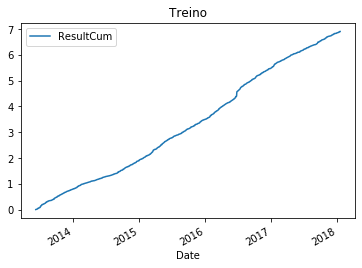

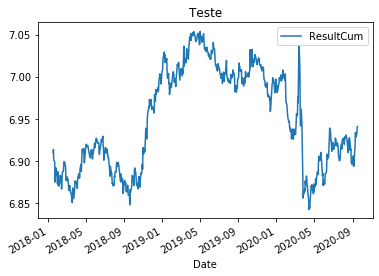

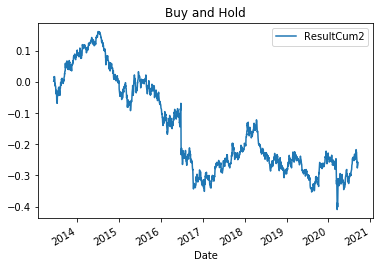

In [92]:
df[:1200].plot( y='ResultCum',title = "Treino")
plt.show()
df[1200:].plot( y='ResultCum',title = "Teste")
plt.show()
df.plot(y = 'ResultCum2', title = "Buy and Hold")
plt.show()

In [141]:
from backtesting import Backtest, Strategy

class ml(Strategy):
    def init(self):
        price = self.data.Close
  
    def next(self):
        price = self.data.Close
        if self.data.alvo == 1 and self.data['Alta/Baixa'] == 0 and price < self.data.Mslow:
            if self.position.is_long:
                return
            self.buy()
            
        if self.data.alvo == 0 and self.data['Alta/Baixa'] == 1 and price > self.data.Mslow:
            if self.position.is_short:
                return
            self.sell()
        else:
            self.position.close()



df['Mfast'] = df['Close'].rolling(8).mean() # Distância entre o preço de hoje e a média curta

df['Mslow'] = df['Close'].rolling(20).mean() # Distância entre o preço de hoje e a média Longa
            
bt = Backtest(df[1200:], ml, commission=0,
              exclusive_orders=True, trade_on_close=True)
stats = bt.run()

print(stats)
bt.plot()


Start                     2018-01-17 00:00:00
End                       2020-09-16 00:00:00
Duration                    973 days 00:00:00
Exposure Time [%]                     58.1197
Equity Final [$]                      25113.9
Equity Peak [$]                       25113.9
Return [%]                            151.139
Buy & Hold Return [%]                 6.22875
Max. Drawdown [%]                          -0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                  217
Win Rate [%]                          99.0783
Best Trade [%]                        1.94828
Worst Trade [%]                             0
Avg. Trade [%]                       0.425268
Max. Trade Duration           3 days 00:00:00
Avg. Trade Duration           2 days 00:00:00
Profit Factor                             NaN
Expectancy [%]                            NaN
SQN                               